In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import igraph as ig
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scanpy as sc
from typing import Literal, Optional
import os
import seaborn as sns
import warnings

In [2]:
plt.style.use('tableau-colorblind10')

In [3]:
# Load the data in backed mode
PCS = 1000
MIN_EDGES = 5
#RESULTS_DIR = f"results-final-{PCS}pcs-{MIN_EDGES}minedges"
RESULTS_DIR = f"results-gmgm-nonsignif"
adata = ad.read_h5ad(f"out/nonsignif-min-{MIN_EDGES}-pcs-{PCS}-E-GEOD-139324.h5ad", backed=True)
adata

AnnData object with n_obs × n_vars = 2200 × 155970 backed at 'out/nonsignif-min-5-pcs-1000-E-GEOD-139324.h5ad'
    obs: 'external_gene_name', 'external_gene_name_nonan', 'cell_count_fewer_than_three_across_all', 'unique_cell_count_across_all', 'cell_count_fewer_than_three_int', 'unique_cell_count_int'
    var: 'individual', 'disease', 'infection', 'organism_part', 'kmeans_9', 'kmeans_15', 'kmeans_21', 'kmeans_24', 'kmeans_29', 'kmeans_48', 'kmeans_64', 'kmeans_81', 'kmeans_93', 'sample', 'gene_count', 'unique_gene_count'
    obsp: 'gene'
    varp: 'cell'

In [4]:
gene_sparsity = adata.obsp['gene'].data.shape[0] / (adata.shape[0] ** 2)
cell_sparsity = adata.varp['cell'].data.shape[0] / (adata.shape[1] ** 2)
gene_sparsity, cell_sparsity

(0.004997933884297521, 0.00010512433716239055)

# Look at how variants cluster together

In [5]:
# Find the variants
allele_vc = adata.obs["external_gene_name"].value_counts()
variants = allele_vc[
    (allele_vc > 1)
    & (allele_vc.index != "Not in Biomart")
    & (allele_vc.index != "Biomart NaN")
]
variants

LST1       8
HLA-DMB    8
HLA-A      7
HLA-C      7
CSNK2B     7
          ..
IGSF6      2
TRBC1      2
PRPF8      2
IFI27      2
CHCHD10    2
Name: external_gene_name, Length: 87, dtype: int64

In [6]:
shape_palette = 100*[
    "circle",
    "rect",
    "diamond",
    "triangle",
    "rect",
    "circle",
    "triangle"
]
color_palette = 100*[
    "#FF9A96",
    "#264589",
    "#FF9A96",
    "#264589",
    "#FF9A96",
    "#264589",
    "#FF9A96"
]

def plot_variant_info(
    variant: str,
    adata: ad.AnnData
) -> tuple[plt.Figure, plt.Axes]:
    vadata = adata[adata.obs["external_gene_name"] == variant]
    graph = vadata.obsp['gene']
    how_many = graph.shape[0]

    try:
        # If the graph is empty, this throws an error!
        graph = ig.Graph.Weighted_Adjacency(graph, mode="undirected").simplify()
    except:
        graph = ig.Graph.Weighted_Adjacency(graph)
    graph.vs["label"] = vadata.obs_names.str.split('ENSG00000').str[-1]
    graph.vs["label_size"] = 5

    # Get connected components of the graph
    components = graph.components()

    # Color vertex by component
    graph.vs["color"] = [color_palette[i] for i in components.membership]

    # Change  vertex shape by component as well
    graph.vs["shape"] = [shape_palette[i] for i in components.membership]


    fig, (ax1, ax2) = plt.subplots(figsize=(14, 7), ncols=2)
    ig.plot(
        graph,
        vertex_size=40,
        target=ax1,
        edge_color="black",
        layout='circle'
    )
    ax1.set_facecolor("white")
    ax1.set_title(f"{variant} (ENSG00000 + ID)")
    ax1.set_xlabel("Colored/shaped by connected components")

    degree_distribution = pd.Series(
        graph.degree(),
        index=graph.vs["label"]
    )
    degree_distribution.sort_values(ascending=False).plot(
        kind="bar",
        ax=ax2
    )
    ax2.set_title(f"Subset degree distribution for {variant} alleles")
    ax2.set_yticks(degree_distribution.unique(), minor=True)
    ax2.set_yticks(range(0, degree_distribution.max() + 2, degree_distribution.max() // 5 + 1), minor=False)
    ax2.yaxis.set_minor_formatter(ticker.ScalarFormatter())
    # make the y axis minor labels smaller
    ax2.tick_params(axis='both', which='minor', labelsize=6)

    ax2.set_ylim(0, degree_distribution.max() + 1)

    # for every unique value in the degree distribution, add a horizontal line
    for value in degree_distribution.unique():
        ax2.axhline(value, color="black", linestyle="--", linewidth=0.5)

    fig.suptitle(f"The {how_many} alleles of {variant}")
    return fig, (ax1, ax2)

In [7]:
# Find number of connected components in every variant
variant_ccs = pd.Series(
    [
        len(ig.Graph.Weighted_Adjacency(adata[adata.obs["external_gene_name"] == variant].obsp['gene']).components())
        for variant in variants.index
    ],
    index=variants.index,
).sort_values(ascending=False)
variant_ccs

HLA-B       5
RPS18       4
ATP9B       3
SERPINF1    2
RPS17       2
           ..
GTF2H2      1
CCL4L2      1
SNHG32      1
IER3        1
CHCHD10     1
Length: 87, dtype: int64

Text(0, 0.5, 'Number of alleles')

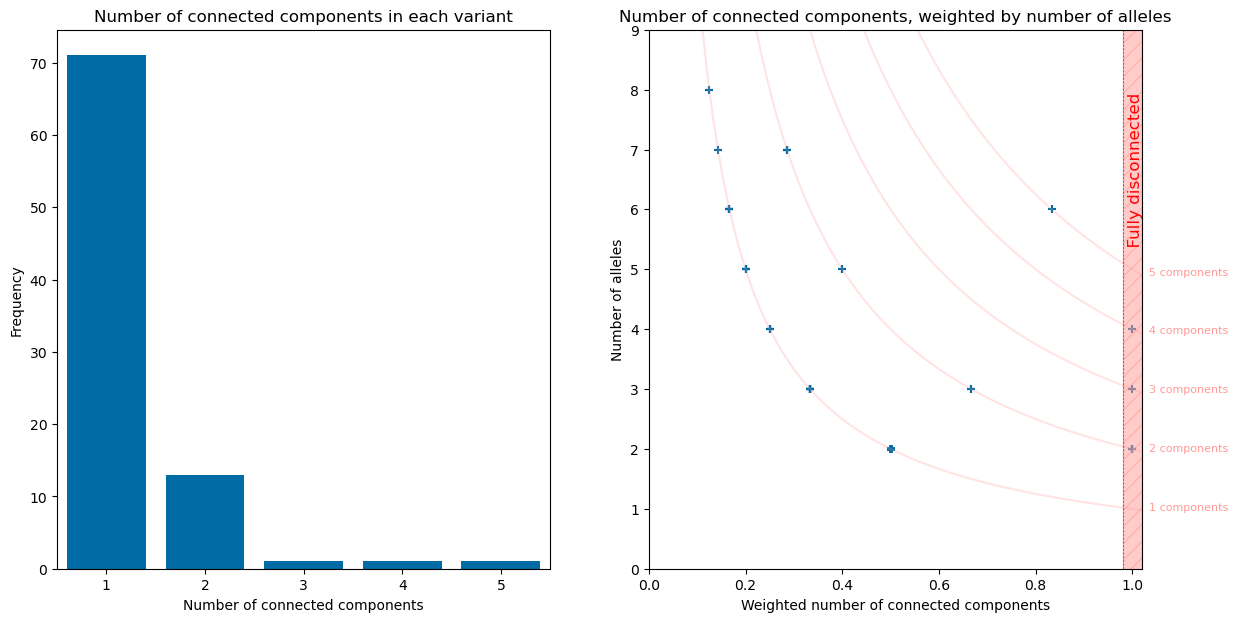

In [8]:
weighted_variant_ccs = variant_ccs / variants[variant_ccs.index]

fig, axs = plt.subplots(figsize=(14, 7), ncols=2)
ax1, ax2 = axs
labels, counts = np.unique(variant_ccs, return_counts=True)
ax1.bar(labels, counts, align='center')
ax2.scatter(
    weighted_variant_ccs,
    variants[variant_ccs.index],
    marker='+'
)

# Draw contours representing numbers of components
for i in [1, 2, 3, 4, 5]:
    xs = np.linspace(0.01, 1.02, 100)
    ys = i / xs
    ax2.plot(
        xs,
        ys,
        color="#FF9A9644",
    )
    plt.text(xs[-1], ys[-1], f'  {i} components', fontsize=8, color="#FF9A96")

# Draw "fully disconnected" box
ax2.axvspan(0.98, 1.02, color="#FF9A9644", alpha=0.5, hatch="//")
ax2.axvline(0.98, color="#FF0000", linestyle="--", linewidth=0.5)
ax2.text(0.99, 5.25, "  Fully disconnected", fontsize=12, color="#FF0000", rotation=90)

# Axis limits
ax1.set_xlim(0.5, variant_ccs.max()+0.5)
ax2.set_xlim(0, 1.02)
ax2.set_ylim(0, variants.max()+1)

# Make sure ax1 ticks are only at integers
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Turn off grid lines
ax1.grid(False)
ax2.grid(False)

ax1.set_title("Number of connected components in each variant")
ax1.set_xlabel("Number of connected components")
ax1.set_ylabel("Frequency")

ax2.set_title("Number of connected components, weighted by number of alleles")
ax2.set_xlabel("Weighted number of connected components")
ax2.set_ylabel("Number of alleles")

Text(0.5, 1.0, 'Allele connectivity')

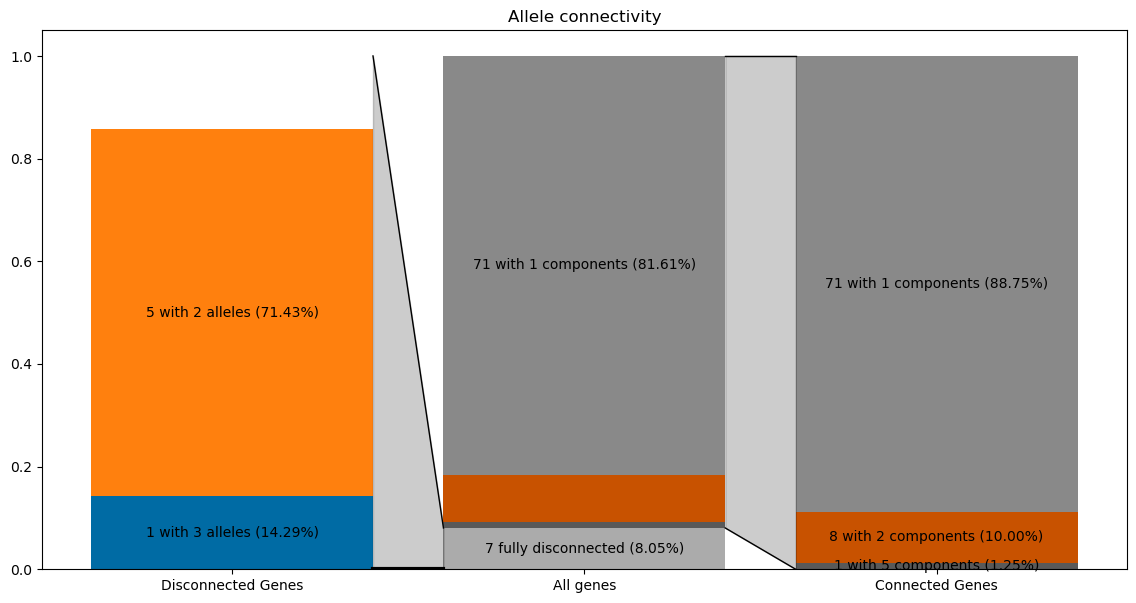

In [9]:
fig, ax = plt.subplots(figsize=(14, 7))

num_disconnected = (weighted_variant_ccs == 1).sum()
fully_disconnected_percent = num_disconnected / weighted_variant_ccs.size

not_disconnected = weighted_variant_ccs != 1
variant_ccs_not_disc = variant_ccs[weighted_variant_ccs.index][not_disconnected]

disconnected = weighted_variant_ccs == 1
variant_ccs_disc = variant_ccs[weighted_variant_ccs.index][disconnected]

# connected components
components_percent = {}
num_components = {}
for i in {1, 2, 3, 4, 5}:
    num_components[i] = (variant_ccs_not_disc == i).sum()
    components_percent[i] = num_components[i] / weighted_variant_ccs.size

# disconnected components
disc_components_percent = {}
num_disc_components = {}
for i in {2, 3, 4, 5, 6, 7}:
    num_disc_components[i] = (variant_ccs_disc == i).sum()
    disc_components_percent[i] = num_disc_components[i] / variant_ccs_disc.size

# Bar plot of just fully disconnected
cur_bottom_disc = 0
bs = []
for i in [3, 2]:
    percent = num_disc_components[i] / num_disconnected
    b = ax.bar(
        ["Disconnected Genes"],
        [percent],
        bottom=[cur_bottom_disc],
        label=f"{i} components"
    )
    cur_bottom_disc += percent
    if num_disc_components[i] != 0:
        ax.bar_label(b, label_type='center', labels=[
            f"{num_disc_components[i]} with {i} alleles ({b[0].get_height():.2%})"
        ])
    bs.append(b)

# Bar plot of disconnected vs not disconnected
b1 = ax.bar(
    ["All genes"],
    [fully_disconnected_percent],
    label="Fully disconnected"
)
if num_disconnected != 0:
    ax.bar_label(b1, label_type='center', labels=[
        f"{num_disconnected} fully disconnected ({x.get_height():.2%})"
        for idx, x in enumerate(b1)
    ])

# Put this bar plot as the primary
bs = [b1] + bs

# Connect the zoom-ins
ax.plot(
    [bs[0][0].get_x(), bs[1][0].get_x() + bs[1][0].get_width()],
    [0, 0],
    color='black',
    linewidth=3
)
ax.plot(
    [bs[0][0].get_x(), bs[1][0].get_x() + bs[1][0].get_width()],
    [bs[0][0].get_height(), 1],
    color='black',
    linewidth=1
)
ax.fill_between(
    [bs[0][0].get_x(), bs[1][0].get_x() + bs[1][0].get_width()],
    [bs[0][0].get_height(), 1],
    [0, 0],
    color='black',
    alpha=0.2,
)

# Reset bs
bs = [b1]

# Bar plot of not fully disconnected with i components
cur_bottom_all = fully_disconnected_percent
cur_bottom_conc = 0
for i in [5, 3, 2, 1]:
    percent = num_components[i] / sum(num_components.values())
    b = ax.bar(
        ["All genes", "Connected Genes"],
        [components_percent[i], percent],
        bottom=[cur_bottom_all, cur_bottom_conc],
        label=f"{i} components"
    )
    cur_bottom_all += components_percent[i]
    cur_bottom_conc += percent
    off1 = ""
    off2 = ""
    if i == 4:
        off2 += ""
    if i == 3:
        off2 += ""
    if i == 2:
        off2 += "" 

    # Don't put the bar label if the number is zero!
    if num_components[i] != 0:
        ax.bar_label(b, label_type='center', labels=[
            "" if i != 1 else f"{num_components[i]} with {i} components ({b[0].get_height():.2%})",
            f"{off1}{num_components[i]} with {i} components ({b[1].get_height():.2%}){off2}"
        ])
    bs.append(b)


# Connect the zoom-ins
ax.plot(
    [bs[0][0].get_x() + bs[0][0].get_width(), bs[1][1].get_x()],
    [1, 1],
    color='black',
    linewidth=1
)
ax.plot(
    [bs[0][0].get_x() + bs[0][0].get_width(), bs[1][1].get_x()],
    [bs[0][0].get_height(), 0],
    color='black',
    linewidth=1
)
ax.fill_between(
    [bs[0][0].get_x() + bs[0][0].get_width(), bs[1][1].get_x()],
    [1, 1],
    [bs[0][0].get_height(), 0],
    color='black',
    alpha=0.2,
)

ax.set_title("Allele connectivity")

In [10]:
variant_ccs_not_disc

HLA-B      5
RPS9       2
LAIR1      2
HLA-E      2
SMDT1      2
          ..
GTF2H2     1
CCL4L2     1
SNHG32     1
IER3       1
CHCHD10    1
Length: 80, dtype: int64

In [11]:
variant_ccs_disc

RPS18       4
ATP9B       3
SERPINF1    2
RPS17       2
METTL9      2
RPL41P2     2
IFI27       2
dtype: int64

# Cluster the genes

In [12]:
GENE_N_GLETON = 1 if MIN_EDGES > 0 else 25

In [13]:
sc.tl.leiden(
    adata,
    resolution=1,
    key_added="leiden_gene",
    obsp='gene',
    random_state=0
)

In [14]:
adata.obs['leiden_gene_processed'] = adata.obs['leiden_gene'].astype('category')
adata.obs['leiden_gene_processed'].cat.add_categories('Singleton', inplace=True)

valcounts = adata.obs['leiden_gene_processed'].value_counts()
adata.obs['leiden_gene_processed'][adata.obs['leiden_gene_processed'].isin(
    valcounts[valcounts <= GENE_N_GLETON].index
)] = 'Singleton'

adata.obs['leiden_gene_processed'] = adata.obs['leiden_gene_processed'].cat.remove_unused_categories()
adata.obs['leiden_gene_processed'].value_counts()

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_26400/2386063501.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata.obs['leiden_gene_processed'].cat.add_categories('Singleton', inplace=True)


0            856
1            248
2            236
Singleton    196
3            112
            ... 
42             2
43             2
44             2
45             2
33             2
Name: leiden_gene_processed, Length: 66, dtype: int64

In [15]:
adata.obs['leiden_gene_processed'].value_counts().drop("Singleton")[:5]

0    856
1    248
2    236
3    112
4     86
Name: leiden_gene_processed, dtype: int64

In [16]:
def create_pathway_df(
    adata: ad.AnnData,
    leiden_string: str = "leiden_gene_processed",
    save: bool = False,
    species: Literal["hsapiens", "mmusculus"] = "hsapiens",
) -> pd.DataFrame:
    gp = GProfiler(return_dataframe=True)
    pathway_df = gp.profile(
        organism=species,
        query={
            f"Module {module}": adata[adata.obs[leiden_string] == module].obs_names.values.tolist()
            for module in adata.obs[leiden_string].unique()
        },
    )
    if save:
        if not os.path.exists(RESULTS_DIR):
            os.makedirs(RESULTS_DIR)
        pathway_df.to_csv(f"./{RESULTS_DIR}/pathways.csv")
    return pathway_df

pathway_df = create_pathway_df(adata, save=True)

In [17]:
pathway_df[pathway_df["query"] == "Module 5"].head(3)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
400,HPA,HPA:0461391,skin 1; cells in basal layer[≥Low],1.163671e-20,True,skin 1; cells in basal layer[≥Low],881,69,37,11019,0.536232,0.041998,Module 5,[HPA:0460000]
410,HPA,HPA:0471391,skin 2; cells in basal layer[≥Low],1.939451e-20,True,skin 2; cells in basal layer[≥Low],962,69,38,11019,0.550725,0.039501,Module 5,[HPA:0470000]
489,HPA,HPA:0471411,skin 2; cells in spinous layer[≥Low],1.369075e-18,True,skin 2; cells in spinous layer[≥Low],871,69,35,11019,0.507246,0.040184,Module 5,[HPA:0470000]


In [18]:
def plot_graph(
    module: str,
    key: str,
    obsp_or_varp: Literal["obsp", "varp"] = "obsp",
    leiden_string: str = "leiden_gene_processed",
    vertex_names: Optional[str] = None,
    top_genes: int = 25,
    top_pathways: int = 10,
    display_centrality: Literal["degree", "harmonic", "eigenvector_centrality", "betweenness"] = "degree",
    save: bool = False,
) -> tuple[tuple[plt.Figure, plt.Axes], ig.Graph]:
    # Create the graph for the specific module
    if obsp_or_varp == "obsp":
        module_idx = adata.obs[leiden_string] == module
        name_source = adata[module_idx].obs_names
        id = adata[module_idx].obs_names
        if vertex_names is not None:
            name_source = adata[module_idx].obs[vertex_names]
        full_graph = adata[module_idx].obsp[key]
    elif obsp_or_varp == "varp":
        module_idx = adata.var[leiden_string] == module
        name_source = adata[module_idx].var_names
        id = adata[module_idx].var_names
        if vertex_names is not None:
            name_source = adata[module_idx].var[vertex_names]
        full_graph = adata[module_idx].varp[key]
    else:
        raise ValueError("obsp_or_varp must be either 'obsp' or 'varp'")
    

    uniques = list(set(name_source.tolist()))

    # Plot and save the graph
    graph = ig.Graph.Weighted_Adjacency(full_graph, mode="undirected").simplify()
    graph.contract_vertices(
        [uniques.index(_) for _ in name_source],
        combine_attrs="first"
    )
    graph.simplify()
    graph.vs["label"] = name_source
    graph.vs["label_size"] = 7
    fig, ax = plt.subplots(figsize=(7, 7))
    ig.plot(
        graph,
        vertex_size=50,
        target=ax,
        edge_color="black",
    )
    ax.set_facecolor("grey")
    ax.set_title(f"Module {module}")
    if save:
        # check if m{module} exists; if not, create it
        if not os.path.exists(f"./{RESULTS_DIR}/m{module}"):
            os.makedirs(f"./{RESULTS_DIR}/m{module}")
        
        plt.savefig(f"./{RESULTS_DIR}/m{module}/graph.png")

        # Select the top 10 pathways for relevant sources
        module_df = pathway_df[pathway_df["query"] == f"Module {module}"]
        res = pd.concat([
            module_df[module_df["source"] == "GO:BP"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "GO:CC"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "GO:MF"].head(top_pathways)[["source", "native", "name", "p_value"]],
            module_df[module_df["source"] == "KEGG"].head(top_pathways)[["source", "native", "name", "p_value"]],
        ])
        res.to_csv(f"./{RESULTS_DIR}/m{module}/top_pathways.csv", index=False)

    return (fig, ax), graph


In [19]:
for module in adata.obs["leiden_gene_processed"].unique():
    if module == "Singleton":
        continue

    # Just look at top 10
    if module not in {"0", "1", "2", "3", "4", "5", "6", "7", "8", "9"}:
        continue

    (fig, _), _ = plot_graph(
        module,
        key="gene",
        save=True,
        vertex_names="external_gene_name",
        top_genes=25,
        top_pathways=10,
        display_centrality="degree",
    )

    # Close figures to prevent notebook slowing down.
    plt.close(fig)